In [1]:
# Import libraries
from IPython.display import display
import numpy as np
from numpy import mean, std, var
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
import neurokit2 as nk
import warnings
warnings.filterwarnings('ignore')

# Import lists
from lists import dyads, num_dyads, participants, num_participants

In [2]:
# Set sampling rate
sampling_rate = 2000
print("Sampling rate:", sampling_rate)

# Set conditions
conditions = ["sit","gaze"]
print("Conditions:", conditions)

# Show number of participants
print("Participants:", num_participants)

# Show number of dyads
print("Dyads:", num_dyads)

Sampling rate: 2000
Conditions: ['sit', 'gaze']
Participants: 8
Dyads: 4


In [3]:
# Gather data for heartrates and RMSSD

rmssd = {}
hr = {}

for con in conditions:
    ecg_raw_2000hz = np.load(f"data/ecg_raw/ecg_raw_{con}.npy")
    ecg = [
        nk.ecg_clean(
            ecg_raw_2000hz[j],
            sampling_rate=sampling_rate,
            method="neurokit")
        for j in participants
    ]
    r_peaks = [
        nk.ecg_peaks(
            ecg[j],
            sampling_rate=sampling_rate,
            method="neurokit",
            correct_artifacts=True)
        for j in participants
    ]
    rmssd[con] = [
        nk.hrv(
            r_peaks[j],
            sampling_rate=2000,
            show=False
        )["HRV_RMSSD"][0]
        for j in participants
    ]
    hr[con] = [
        sum(r_peaks[j][0]["ECG_R_Peaks"])/\
            ((len(ecg[j])/(sampling_rate*60)))
        for j in participants
    ]

In [4]:
# Calculate average heart rates and RMSSD
for con in conditions:
    print(f"Average heart rates per person in condition {con.upper()}")
    # Save data as 3D array
    for k,x in enumerate(participants[::2]):  # index for dyads
        print(f"Dyad {k} | Female: {hr[con][x]} Male: {hr[con][x+1]}")

# Build dataframe
print("\nAverage heart rates over all participants")
hr_mean = pd.DataFrame(
    {"Female": [
        np.mean(hr["sit"][0::2]),
        np.mean(hr["gaze"][0::2]),
        np.mean([*hr["sit"][0::2],
                 *hr["gaze"][0::2]])],
     "Male": [
        np.mean(hr["sit"][1::2]),
        np.mean(hr["gaze"][1::2]),
        np.mean([*hr["sit"][1::2],
                 *hr["gaze"][1::2]])],
     "All":  [
        np.mean(hr["sit"]),
        np.mean(hr["gaze"]),
        np.mean([*hr["sit"],
                 *hr["gaze"]])]},
    index=["SIT", "GAZE", "All"])

hr_mean = hr_mean.round()
display(hr_mean.T)

print("Average RMSSD over all participants")
rmssd_mean = pd.DataFrame(
    {"Female": [
        np.mean(rmssd["sit"][0::2]),
        np.mean(rmssd["gaze"][0::2]),
        np.mean([*rmssd["sit"][0::2],
                 *rmssd["gaze"][0::2]])],
     "Male": [
        np.mean(rmssd["sit"][1::2]),
        np.mean(rmssd["gaze"][1::2]),
        np.mean([*rmssd["sit"][1::2],
                 *rmssd["gaze"][1::2]])],
     "All":  [
        np.mean(rmssd["sit"]),
        np.mean(rmssd["gaze"]),
        np.mean([*rmssd["sit"],
                 *rmssd["gaze"]])]},
    index=["SIT", "GAZE", "All"])

rmssd_mean = rmssd_mean.round()
display(rmssd_mean.T)

Average heart rates per person in condition SIT
Dyad 0 | Female: 72.4 Male: 60.2
Dyad 1 | Female: 70.0 Male: 69.6
Dyad 2 | Female: 92.6 Male: 76.2
Dyad 3 | Female: 82.0 Male: 77.2
Average heart rates per person in condition GAZE
Dyad 0 | Female: 70.8 Male: 60.8
Dyad 1 | Female: 73.4 Male: 66.8
Dyad 2 | Female: 91.6 Male: 78.4
Dyad 3 | Female: 74.8 Male: 72.6

Average heart rates over all participants


,SIT,GAZE,All
Female,79.0,78.0,78.0
Male,71.0,70.0,70.0
All,75.0,74.0,74.0


Average RMSSD over all participants


,SIT,GAZE,All
Female,26.0,33.0,29.0
Male,45.0,42.0,43.0
All,35.0,37.0,36.0


### Bootstrapping & confidence interval

In [5]:
# Define functions
def cohend(d1, d2):
	"""Function to calculate Cohen's d for independent samples d1 and d2.
 
 	based on https://machinelearningmastery.com/effect-size-measures-in-python/

	Returns:
        float: effect size
	"""
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = mean(d1), mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

def draw_bs_replicates(data,func,size):
    """Creates a bootstrap sample, computes replicates and returns replicates array.
    
    based on: https://github.com/Bhasfe/statistics/blob/master/bootstrapping/Confidence%20Interval%20with%20bootstrapping.ipynb
    """
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

def confidence_interval(bs_replicates, confidence=0.95):
    """ Create two sided conficence interval values."""
    m = mean(bs_replicates)
    # Get the corresponding values of 2.5th and 97.5th percentiles
    lower, upper = np.percentile(
        bs_replicates,
        [((1-confidence)/2)*100,
            ((1-confidence)/2+confidence)*100])
        
    return m, upper, lower

#### HR

In [6]:
# Bootstrapping
sexes = ["Frau","Mann"]
hr_bs = {}
for con in ["sit","gaze"]: hr_bs[con] = {}  # prepare nested dictionary

for con in ["sit","gaze"]:
    for i,sex in enumerate(sexes): 
        # Draw 10000 bootstrap replicates
        hr_bs[con][sex] = draw_bs_replicates(hr[con][i::2],np.mean,15000)

Cohens d SIT: 0.92 
Cohens d GAZE: 0.93
diff: 0.011184482994915035


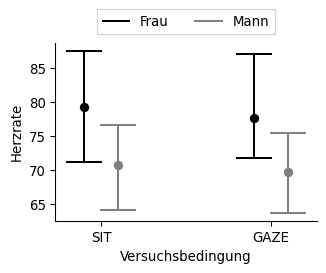

In [7]:
# Plot data
horizontal_line_width=len(conditions)*0.1

fig = plt.figure(figsize=(3.5,3), dpi=96)
for j,con in enumerate(["sit","gaze"]):
    for i,sex in enumerate(sexes): 
        if sex == sexes[0]:
            dis = 0
            color = "k"
        elif sex == sexes[1]:
            dis = 0.2
            color = "grey"
        m, upper, lower = confidence_interval(hr_bs[con][sex])
        plt.plot(dis+j, m, 'o', color=color)
        plt.plot([dis+j, dis+j], [upper, lower], color=color, label = sex if j == 0 else "")
        # Horizontal bar
        left = dis+j - horizontal_line_width / 2
        right = dis+j + horizontal_line_width / 2
        plt.plot([left, right], [upper, upper], color=color)
        plt.plot([left, right], [lower, lower], color=color)
    plt.xticks([0+dis/2, 1+dis/2], ['SIT', 'GAZE'])
    plt.ylabel('Herzrate')
    plt.xlabel('Versuchsbedingung')
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.12), fancybox=False, shadow=False, ncol=2)
        
fig.tight_layout()
sns.despine()
plt.savefig("plots/bootstrap_hr.png", dpi=512, bbox_inches='tight')

# Calculate Cohen's d between two samples
d_sit = cohend(
    hr["sit"][0::2],
    hr["sit"][1::2])
d_gaze = cohend(
    hr["gaze"][0::2],
    hr["gaze"][1::2])

print('Cohens d SIT: %.2f' % d_sit,
      '\nCohens d GAZE: %.2f' % d_gaze)
print(f'diff: {d_gaze-d_sit}')

#### RMSSD

In [8]:
# Bootstrapping
rmssd_bs = {}

for con in ["sit","gaze"]:
    # Draw 10000 bootstrap replicates
    rmssd_bs[con] = draw_bs_replicates(rmssd[con],np.mean,15000)


Cohens d RMSSD: -0.08


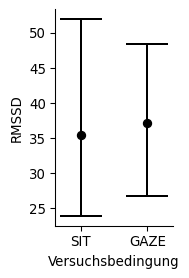

In [9]:
# Plot data
horizontal_line_width=len(conditions)*0.3
color="k"

fig = plt.figure(figsize=(2,3), dpi=96)
for j,con in enumerate(["sit","gaze"]):
    # Get values for confidence interval (mean, upper, lower)
    m, upper, lower = confidence_interval(rmssd_bs[con])
    plt.plot(j, m, 'o', color=color)
    plt.plot([j, j], [upper, lower], color=color)
    # Horizontal bar
    left = j - horizontal_line_width / 2
    right = j + horizontal_line_width / 2
    plt.plot([left, right], [upper, upper], color=color)
    plt.plot([left, right], [lower, lower], color=color)
    plt.xticks([0, 1], ['SIT', 'GAZE'])
    plt.ylabel('RMSSD')
    plt.xlabel('Versuchsbedingung')
    
        
fig.tight_layout()
sns.despine()
plt.savefig("plots/bootstrap_rmssd.png", dpi=512, bbox_inches='tight')

# Calculate Cohen's d between two samples
d_rmssd = cohend(rmssd["sit"],
                 rmssd["gaze"])

print('\nCohens d RMSSD: %.2f' %d_rmssd)

Empirical mean: 35.40100882373546
Bootstrap replicates mean: 35.379480978562064


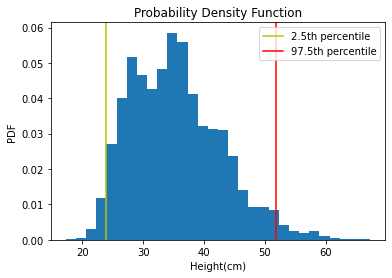

In [10]:
# Sanity check
# Print the mean of bootstrap replicates
heights_std = np.std(rmssd["sit"])
heights_mean = np.mean(rmssd["sit"])

print("Empirical mean: " + str(heights_mean))
print("Bootstrap replicates mean: " + str(np.mean(rmssd_bs["sit"])))

# Plot probability density function
plt.hist(rmssd_bs["sit"],bins=30,density=True)
plt.axvline(x=np.percentile(rmssd_bs["sit"],[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(rmssd_bs["sit"],[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')
plt.xlabel("Height(cm)")
plt.ylabel("PDF")
plt.title("Probability Density Function")
plt.legend()
plt.show()